# Guide on how to use the backtester

In [26]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [27]:
from datamodel import OrderDepth, UserId, TradingState, Order


class Trader:
    def __init__(self):
        # config
        self.position_limit = {"RAINFOREST_RESIN": 50}
        self.symbol = "RAINFOREST_RESIN"

        # self.sk1 = 0.00
        # self.sk2 = 0.00
        # self.sk3 = 1.0
        # self.sk4 = 0.0
        # self.sk5 = 0.00
        # self.bk1 = 0.00
        # self.bk2 = 0.00
        # self.bk3 = 0.75
        # self.bk4 = 0.25
        # self.bk5 = 0.00

        self.sk1 = 0.00
        self.sk2 = 0.00
        self.sk3 = 0.00
        self.sk4 = 0.00
        self.sk5 = 0.00
        self.sk6 = 0.00
        self.sk7 = 1.00

        self.bk1 = 0.00
        self.bk2 = 0.00
        self.bk3 = 0.00
        self.bk4 = 0.00
        self.bk5 = 0.00
        self.bk6 = 0.00
        self.bk7 = 1.00

        # runtime
        self.max_position = 0
        self.min_position = 0
        pass

    # takes +ev orders from the orderbook.
    def take_best_orders(self, state: TradingState, orderbook: OrderDepth) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

        if len(orderbook.buy_orders) != 0:
            best_bid_price = max(orderbook.buy_orders.keys())
            best_bid_volume = orderbook.buy_orders[best_bid_price]

            if best_bid_price > 10000:
                fill_quantity = min(max_sell_amount, best_bid_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_bid_price, -fill_quantity))
                    del orderbook.buy_orders[best_bid_price]

        if len(orderbook.sell_orders) != 0:
            best_ask_price = min(orderbook.sell_orders.keys())
            best_ask_volume = abs(orderbook.sell_orders[best_ask_price])

            if best_ask_price < 10000:
                fill_quantity = min(max_buy_amount, best_ask_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_ask_price, fill_quantity))
                    del orderbook.sell_orders[best_ask_price]

        return orders

    # puts in some quoting orders
    def add_mm_orders(self, state: TradingState) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

        portion = max_sell_amount / 7
        sq1 = self.sk1 * portion
        sq2 = self.sk2 * portion
        sq3 = self.sk3 * portion
        sq4 = self.sk4 * portion
        sq5 = self.sk5 * portion
        sq6 = self.sk6 * portion
        sq7 = self.sk7 * (max_sell_amount - 6 * int(portion))

        portion = max_buy_amount / 7
        bq1 = self.bk1 * portion
        bq2 = self.bk2 * portion
        bq3 = self.bk3 * portion
        bq4 = self.bk4 * portion
        bq5 = self.bk5 * portion
        bq6 = self.bk6 * portion
        bq7 = self.bk7 * (max_buy_amount - 6 * int(portion))

        orders.append(Order(self.symbol, 10001, -int(sq1)))
        orders.append(Order(self.symbol, 10002, -int(sq2)))
        orders.append(Order(self.symbol, 10003, -int(sq3)))
        orders.append(Order(self.symbol, 10004, -int(sq4)))
        orders.append(Order(self.symbol, 10005, -int(sq5)))
        orders.append(Order(self.symbol, 10006, -int(sq6)))
        orders.append(Order(self.symbol, 10007, -int(sq7)))

        orders.append(Order(self.symbol, 9999, int(bq1)))
        orders.append(Order(self.symbol, 9998, int(bq2)))
        orders.append(Order(self.symbol, 9997, int(bq3)))
        orders.append(Order(self.symbol, 9996, int(bq4)))
        orders.append(Order(self.symbol, 9995, int(bq5)))
        orders.append(Order(self.symbol, 9994, int(bq6)))
        orders.append(Order(self.symbol, 9993, int(bq7)))

        return orders

    def init_runtime_variables(self, state: TradingState):
        self.max_position = state.position[self.symbol] if self.symbol in state.position else 0
        self.min_position = state.position[self.symbol] if self.symbol in state.position else 0

    def run(self, state: TradingState):
        self.init_runtime_variables(state)

        result = {}
        for product in state.order_depths:
            orders: list[Order] = []

            if product == "RAINFOREST_RESIN":
                took = self.take_best_orders(state, state.order_depths[product])

                while len(took) != 0:
                    orders = orders + took

                    for order in took:
                        if order.quantity > 0:
                            self.max_position += order.quantity
                        elif order.quantity < 0:
                            self.min_position -= abs(order.quantity)

                    took = self.take_best_orders(state, state.order_depths[product])

                took = self.add_mm_orders(state)
                orders = orders + took

                for order in took:
                    if order.quantity > 0:
                        self.max_position += order.quantity
                    elif order.quantity < 0:
                        self.min_position -= abs(order.quantity)

            result[product] = orders
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData


Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [ ]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [ ]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    # "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
    # "MAGNIFICENT_MACARONS": 10,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_5_day_2, trades_round_5_day_2)


bt.run()


# double layer dictionary.

totalpnl = bt.pnl()["spreadcrossing"]["total"]
totalpnl, bt.pnl()

(34115.0,
 {'spreadcrossing': {'RAINFOREST_RESIN': 34115.0, 'total': 34115.0},
  'midpoint': {'RAINFOREST_RESIN': 22384.0, 'total': 22384.0}})

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

Let's look at some metrics now.

Note:
- `get_metric` function is now deleted.
- `bt.pnl` is also deleted.
- If you want metrics, use `calculate_metrics(product)`.

Old way:
    bt.get_metric('midpoint_sharpe', 'KELP')

New way:
    metrics = bt.calculate_metrics('KELP')
    metric = metrics['midpoint_sharpe']

Available metrics:
0: timestamp
1: spreadcrossing_pnl
2: spreadcrossing_final_pnl
3: spreadcrossing_sharpe
4: spreadcrossing_pnl_bps
5: midpoint_pnl
6: midpoint_final_pnl
7: midpoint_sharpe
8: midpoint_pnl_bps
9: position


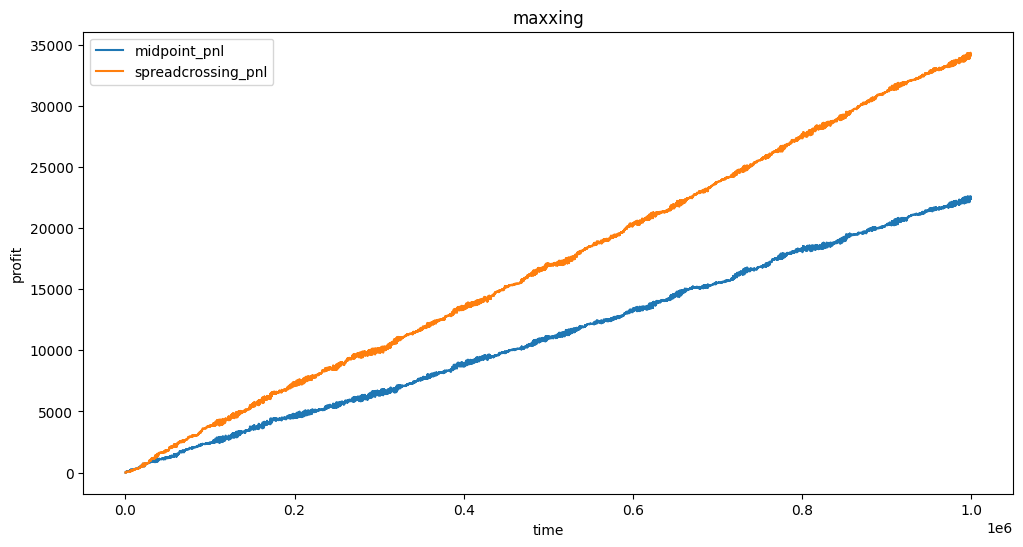

In [30]:
metrics = bt.calculate_metrics("RAINFOREST_RESIN")

print(f"Available metrics:")
for idx, key in enumerate(metrics.keys()):
    print(f"{idx}: {key}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
plt.title("maxxing")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()